# **DL-ESP-002-NOV22: Proyecto Final de Deep Learning**
#### Autor: &ensp;&ensp;Rafael Dalzotto
#### Email: &ensp;&ensp;rdalzotto@itba.edu.ar

Este cuaderno contiene el desarrollo de mi proyecto final para el curso de [Deep Learning del MIT xPRO](https://xpro.mit.edu/courses/course-v1:xPRO+DLx/).
El objetivo de la actividad es crear un modelo de deep learning para resolver un posible problema de la vida real a partir de algun modelo pre-entrenado utilizando transfer-learning, con el unico fin de evaluar algunas de las herramientas que aprendimos durante el curso.

*Nota: No tengo ninguna manera de utilizar acentos aqui, sepan disculpar.*

## Problematica y datos
Para este proyecto he elegido como problematica, la **determinacion automatizada** de la calidad de productos citricos, especificamente de **limones** (fruta sin procesar).

La produccion de Limones es historicamente la mas importante del mercado citrico de Argentina, llegando a veces a rozar el millon de toneladas de produccion anual *(independientemente de si son destinadas a exportacion o consumo local, o de su postprocesado)*, lo cual puede verse en datos historicos como por ejemplo en [este documento del INTA](https://inta.gob.ar/sites/default/files/script-tmp-inta_manual_citricultura_cap3.pdf), como tambien en [esta noticia del Ministerio de Agricultura, Ganaderia y Pesca](https://www.argentina.gob.ar/noticias/calidad-y-sanidad-para-potenciar-la-productividad-de-la-citricultura-argentina) o en [esta Infografia de SENASA](http://www.senasa.gob.ar/sites/default/files/ARBOL_SENASA/INFORMACION/INFORMES%20Y%20ESTADISTICAS/Informes%20y%20estadisticas%20Vegetal/FRUTALES/citricos_argentinos_de_excelencia.pdf).


La apariencia y condicion fisica del producto es uno de los factores mas importantes para determinar el precio final, mercado objetivo y la competitividad del producto, esto puede verse con mas profundidad en [este articulo de la FAO](https://www.fao.org/3/y4893s/y4893s08.htm). Los productos son segmentados y ordenados de acuerdo a estas caracteristicas. 

## Tecnologias y estado del arte

Para determinar la calidad de los limones de manera automatizada, utilizare herramientas ampliamente probadas del ambito de la [Vision Computacional](https://www.ibm.com/ar-es/topics/computer-vision), especificamente para la clasificacion de imagenes.

Si bien historicamente, las [Redes Neuronales Convolucionales (CNN)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) son muy predominantes en el ambito de la vision computacional para la clasificacion de imagenes *(como por ejemplo con las distintas versiones de [AlexNet](https://medium.com/analytics-vidhya/concept-of-alexnet-convolutional-neural-network-6e73b4f9ee30), [VGG](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/), [ResNet](https://datagen.tech/guides/computer-vision/resnet/), [Inception](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202), [etc](https://iq.opengenus.org/different-types-of-cnn-models/))*, con el surgimiento de los [Transformers en 2017](https://arxiv.org/abs/1706.03762) y su gran impacto posterior en modelos como [BERT o GPT](https://daleonai.com/transformers-explained) su uso se extendio a areas fuera del [NLP](https://aws.amazon.com/es/what-is/nlp/) como lo es la vision computacional.

Este primer paso lo dieron los [Vision Transformers (ViT)](https://machinelearningmastery.com/the-vision-transformer-model/), presentados por primera vez en 2020 en el paper [*An Image Is Worth 16x16 Words*](https://arxiv.org/abs/2010.11929) con la novedad de que la arquitectura no utilizaba ningun tipo de capa convolutiva, logrando convertirse en el estado del arte en aquel entonces y superando a [EfficientNet-L2](https://paperswithcode.com/paper/meta-pseudo-labels) en rendimiento Top 1% sobre ImageNet.

La idea sera probar este modelo para la tarea de clasificacion de limones. Sin embargo hay que tener cuidado ya que los Vision Transformers tienen problemas relacionados con sesgos inductivos, [resueltos posteriormente en modelos hibridos *(este es solo un ejemplo)*](https://paperswithcode.com/paper/coatnet-marrying-convolution-and-attention), por lo que al dia de hoy no son el estado del arte.

## Seleccion del Modelo

Para el clasificador de limones, utilizare el modelo [ViT-Base](https://huggingface.co/google/vit-base-patch16-224) propuesto en [este paper (Tabla 1)](https://arxiv.org/abs/2010.11929). Este modelo acumula un total de 86 millones de parametros y su arquitectura esta compuesta por 12 capas de [Transformer Encoders](https://jalammar.github.io/illustrated-transformer/) utilizados para extraer atributos y una [capa lineal](https://androidkt.com/pytorch-linear-layer-fully-connected-layer-explained/) al final para obtener la [distribucion de probabilidades de clases](https://www.scribbr.com/statistics/probability-distributions/).

El modelo ya se encuentra pre-entrenado con el dataset [ImageNet-21k](https://www.image-net.org/) (+14 milliones de imagenes, 21.843 de clases) y finamente ajustado (fine-tuned) con el dataset [ImageNet-1K](https://huggingface.co/datasets/imagenet-1k)  (+1.5 millones de imagenes y 1000 categorias), por lo que el output de la capa (lineal) final tiene 1000 salidas.

## Dataset y modificacion del modelo

Como conjunto de datos utilizare [Lemons quality control dataset](https://github.com/robotduinom/lemon_dataset) que consiste en un conjunto de 2076 imagenes de limones en buen o mal estado y 452 imagenes del fondo (sin limones), por lo que este dataset esta conformado por 3 clases: "Buen Estado", "Mal Estado", y "Vacio". El objetivo sera que el modelo aprenda a diferenciar entre estas categorias al recibir una imagen.

Para ello modificare el modelo ViT-Base, especificamente la ultima capa lineal, la cual la reemplazare por una nueva capa lineal con 3 salidas (para las 3 clases), con sus parametros inicializados [por default, con una distribucion uniforme](https://pytorch.org/tutorials/prototype/skip_param_init.html).

## Estrategia de Transfer-Learning
Como estrategia de transfer-learning, realizare el fine-tuning en dos etapas:
1. En la Primera Etapa congelare todos los parametros de la red excepto los de la ultima capa lineal y entrenare el modelo con un ratio de aprendizaje generoso
2. En la Segunda Etapa, dejare congelados los pesos de los encoders del 0 al 5 inclusive, y descongelare los encoders del 6 al 11 inclusive, pero utilizare un ratio de aprendizaje varios ordenes menor que en la primera etapa, para evitar el [olvido catastrofico](https://en.wikipedia.org/wiki/Catastrophic_interference) de las caracteristicas del modelo preentrenado.

# DESCARGO DE RESPONSABILIDAD
Por cuestiones de tiempo, este modelo de deep learning fue creado y entrenado unicamente con fines academicos y carece de toda la rigurosidad necesaria  para ser utilizado en entornos industriales y reales, su correcto funcionamiento no esta garantizado en ningun caso. 

Para mas informacion, enviame un correo a rdalzotto@itba.edu.ar

## Seleccion del modelo

PyTorch incluye muchos modelos preentrenados. [Aqui hay una lista completa de los relacionados con herramientas de vision artificial](https://pytorch.org/vision/stable/models.html#classification), entre otras herramientas.

Ademas, [esta es la documentacion de VIT_B_16](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) en Pytorch.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuracion del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso sera mucho mas rapido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Importa un modelo ViT-Base preentrenado con ImageNet-1K
vit_b16 = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1, progress=True).to(device)

print("model:", vit_b16)

device: cuda
model: VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=T

## Conjunto de datos

Para cargar el conjunto de datos [Lemon quality control dataset](https://github.com/robotduinom/lemon_dataset), utilizare Google Drive porque funciona muy bien en conjunto con Google Colab, simplemente tengo que tener todas las imagenes en carpetas ordenadas dentro de mi drive y montar la unidad a este cuaderno.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode

import torchvision.transforms.functional as TF

# Utilizo una transformacion personalizada para recortar bordes sobrantes de imagenes rectangulares (si existen, sino dejo como esta)
class CenterCropMin:
    def __call__(self, tensor):
        height, width = tensor.shape[-2:]
        min_dim = min(height, width)
        top = (height - min_dim) // 2
        left = (width - min_dim) // 2
        tensor = tensor[..., top:top+min_dim, left:left+min_dim]
        return tensor

# Estas son las transformaciones que se aplicaran antes de pasar las imagenes al modelo (especificadas segun la documentacion de VIT_B_16)
inference_transforms = transforms.Compose([
    transforms.ToTensor(),
    CenterCropMin(),
    transforms.Resize([224,224], interpolation=InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Antitransformar solo para visualizar las imagenes (sino Matplotlib recorta los valores negativos y se pierde informacion)
antiTransform = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

# Cargo el dataset desde la carpeta de drive con las transformaciones requeridas por el modelo
lemon_dataset = ImageFolder('/content/drive/MyDrive/Computadora/MIT ML/lemon_dataset', transform=inference_transforms)

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y validacion

# Defino las proporciones para cada particion (60% train, 20% validation, 20% test)
train_size = int(0.6 * len(lemon_dataset))
val_size = int(0.2 * len(lemon_dataset))
test_size = len(lemon_dataset) - train_size - val_size

generator=torch.Generator().manual_seed(42) # Semilla para repetibilidad

# Distribuir los datos aleatoriamente con random_split
train_set, val_set, test_set = torch.utils.data.random_split(lemon_dataset, [train_size, val_size, test_size], generator=generator)

In [ ]:

# Creamos DataLoaders con un batch_size de 48 imagenes por batch (Utilizo este valor para cuidar la memoria del entorno de ejecucion)
batch_size = 48
dataloaders = {'train': DataLoader(train_set, batch_size=batch_size),
               'val': DataLoader(val_set, batch_size=batch_size),
               'test': DataLoader(test_set, batch_size=batch_size)}

dataset_sizes = {'train': len(train_set),
                 'val': len(val_set),
                 'test': len(test_set)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1516, 'val': 505, 'test': 507}


In [ ]:
# Primero, definir el numero total de clases:
lemon_labels = {0, 1, 2}
        

## Visualizacion

Ahora, visualizaremos el conjunto de datos para ver algunas de las imagenes y clases con las que estamos trabajando.

In [ ]:
# Trazar una ground truth sobre las cifras y autocodificar

def view_lemon(tensor):
    image = antiTransform(tensor).cpu().detach().permute((1,2,0))
    plt.imshow(image)

def view_lemon_class(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # Solo queremos ver una clase determinada
            if (labels[i] != label):
                continue
            # Trazar la ground truth
            fig.add_subplot(1, count, idx)

            view_lemon(input)
            
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

def view_lemon_all():
    for i in range(3):
        view_lemon_class(i, 3)

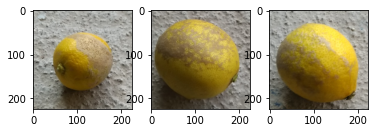

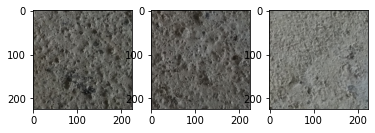

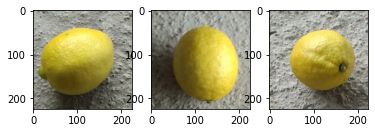

In [ ]:
view_lemon_all()
# Ignoren los Warnings de Matplotlib, las imagenes se observan correctamente

## Categorias

Como pueden observar en la imagen anterior, las categorias son las siguentes:

| Indice | Categoria Limon | 
| :-------: | :----------------------: |
| 0 | Mal estado |
| 1 | Vacio / Nada |
| 2 | Buen estado |

## Prueba del modelo pre-entrenado ViT-Base 16

Antes de hacer cualquier cosa, primero probare si el modelo pre-entrenado funciona correctamente con las imagenes que tengo, para tambien veriricar que las imagenes y los tensores se cargan correctamente y que las transformaciones funcionan bien. Para ello hare una clasificacion simple con una imagen de un limon en mal estado y ciertamente dificil de identificar, y veremos si el modelo lo clasifica correctamente como un **limon**, el cual segun el dataset de [ImageNet-1K le corresponde el **codigo 951**](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) a dicha categoria.

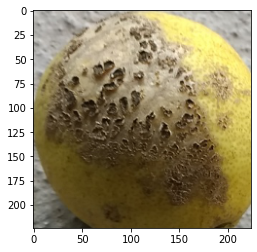

In [ ]:
fig = plt.figure(figsize=(4,4))

idx = 502 # Este es el indice de un limon dificil de identificar, si, me tomo bastante tiempo encontrarlo.
badLemon = dataloaders["train"].dataset[idx][0].unsqueeze(0)

view_lemon(badLemon.squeeze(0)) # Visualizamos el limon que vamos a clasificar con VIT_B_16

# Normalizo las probabilidades de salida del modelo con Softmax
vit_out = torch.softmax(vit_b16.forward(badLemon.to(device)), dim=1)

In [ ]:
sorted_out, indices = torch.sort(vit_out.squeeze(), descending=True)

# Print the top 5 values and their indices
for i in range(5):
    print(f"{i+1}: Value {sorted_out[i]}, Index {indices[i]}")

1: Value 0.36645957827568054, Index 951
2: Value 0.10355188697576523, Index 722
3: Value 0.0789249911904335, Index 940
4: Value 0.02739553526043892, Index 990
5: Value 0.023293863981962204, Index 753


### Funciona correctamente
Como pueden ver, VIT_B_16 pre-entrenado, retorna como primera probabilidad a un Limon (codigo 951) con un 36,6% de certeza, y en segundo lugar a una bola de ping pong (codigo 722) con un 10% de certeza. Esto significa que el clasificador funciona y las imagenes fueron bien interpretadas por el modelo.

### Luego congelare todos los parametros de la red para que no se optimicen en la etapa 1.

In [ ]:
# Congelar todos los pesos de la red
for param in vit_b16.parameters():
    param.requires_grad = False


## Modificar el modelo

Ahora voy a cambiar la ultima capa del modelo para que clasifique las 3 clases de nuestro problema.
Esta nueva capa que agrego, va a tener los pesos descongelados para que se optimicen.

In [ ]:
# Cambiar la ultima capa para que contenga tantos outputs como clases hay en el conjunto de datos
# Por defecto, los pesos de las nuevas capas no estan congelados.

vit_b16.heads.head  = nn.Linear(vit_b16.heads.head.in_features, len(lemon_labels)).to(device)
device

device(type='cuda')

## Entrenar el modelo

Ahora vamos a centrarnos en afinar solo la ultima capa de clasificacion. Posteriormente cuando ese entrenamiento haya convergido, descongelaremos la ultima mitad de la red y pasaremos a la segunda fase de entrenamiento. Se ha demostrado que dividir el entrenamiento de esta manera permite que el modelo alcance un rendimiento optimo.

In [ ]:

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_acc = 0.0
    best_epoch = 0

   # Cada ciclo tiene una fase de entrenamiento, validacion y prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolucion de la perdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluacion
                
            running_loss = 0.0
            running_corrects = 0

           # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parametros
                optimizer.zero_grad()

                # Metodo forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Metodo backward y actualizacion de los pesos solo si esta en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si ha alcanzado la mayor precision
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves


## Fase 1 de Entrenamiento

Ahora, comenzaremos la fase de entrenamiento 1. En esta fase, se congelan los pesos de todas las capas, salvo los de la ultima. Eso nos permite utilizar la red preentrenada como "extractor de atributos" y, despues, afinar la ultima capa de clasificacion para la tarea que queremos realizar.

In [ ]:
learning_rate = 0.001
num_epochs = 15

In [ ]:
# Perdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizo CrossEntropyLoss como funcion de perdida para la clasificacion
optimizer = torch.optim.Adam(vit_b16.parameters(), lr=learning_rate) # Utilizo el algoritmo Adam como optimizador...
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # con un decaimiento exponencial del ratio de aprendizaje

# Entrenar al modelo. Tambien actualizaremos los resultados del entrenamiento para poder visualizarlos
vit_b16_phase1, training_curves_phase1 = train_classification_model(vit_b16, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
----------
train Loss: 0.2038 Acc: 0.9400
val   Loss: 0.0686 Acc: 0.9782
test  Loss: 0.0641 Acc: 0.9744

Epoch 2/15
----------
train Loss: 0.0525 Acc: 0.9861
val   Loss: 0.0475 Acc: 0.9861
test  Loss: 0.0412 Acc: 0.9862

Epoch 3/15
----------
train Loss: 0.0367 Acc: 0.9908
val   Loss: 0.0377 Acc: 0.9921
test  Loss: 0.0318 Acc: 0.9921

Epoch 4/15
----------
train Loss: 0.0279 Acc: 0.9947
val   Loss: 0.0314 Acc: 0.9921
test  Loss: 0.0263 Acc: 0.9921

Epoch 5/15
----------
train Loss: 0.0225 Acc: 0.9967
val   Loss: 0.0272 Acc: 0.9921
test  Loss: 0.0227 Acc: 0.9921

Epoch 6/15
----------
train Loss: 0.0189 Acc: 0.9967
val   Loss: 0.0243 Acc: 0.9921
test  Loss: 0.0202 Acc: 0.9941

Epoch 7/15
----------
train Loss: 0.0165 Acc: 0.9974
val   Loss: 0.0224 Acc: 0.9921
test  Loss: 0.0184 Acc: 0.9961

Epoch 8/15
----------
train Loss: 0.0147 Acc: 0.9980
val   Loss: 0.0210 Acc: 0.9921
test  Loss: 0.0170 Acc: 0.9961

Epoch 9/15
----------
train Loss: 0.0133 Acc: 0.9980
val   Loss: 0.0201

# Fase 1 Resultados

|   Learn Rate  | Epochs  | Val Acc | Test Acc |
| :-----------: | :-----: | :-----: | :------: |
| 1E-3 | 15 | 0.994 | 0.998 |


### Guardar checkpoint de resultados en Drive (Ignorar)
Esto lo utilizo para hacer backups del estado del modelo, porque como consume mucha memoria de la instancia de Google Colab, a veces la sesion me crashea y pierdo el trabajo hecho.

In [ ]:
torch.save(vit_b16_phase1.state_dict(), 'vit_lemons_weights_phase1_15eps.pth')

In [ ]:
# Copiar los pesos desde la carpeta local y guardarlos en Drive
!cp vit_lemons_weights_phase1_15eps.pth '/content/drive/MyDrive/Computadora/MIT ML/vit_checkpoints/'

### Cargar checkpoints de resultados desde Drive (Ignorar)

In [ ]:
# Copiar los pesos guardados en Drive y traerlos a la carpeta Local
!cp '/content/drive/MyDrive/Computadora/MIT ML/vit_checkpoints/vit_lemons_weights_phase1_15eps.pth' '/content/'

In [ ]:
state_dict = torch.load('vit_lemons_weights_phase1_15eps.pth', map_location=device)

vit_b16.load_state_dict(state_dict)
vit_b16_phase1 = vit_b16

### Visualizar las curvas de entrenamiento y los resultados

In [ ]:
import gc

def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en modo de evaluacion
    all_labels = torch.tensor([])
    all_scores = torch.tensor([])
    all_preds = torch.tensor([])
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels.detach().cpu()), 0)
        all_scores = torch.cat((all_scores, scores.detach().cpu()), 0)
        all_preds = torch.cat((all_preds, preds.detach().cpu()), 0)
        del inputs, labels
        gc.collect()
    return all_preds, all_labels, all_scores

def plot_metrics(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

    ncm = metrics.confusion_matrix(labels, preds, normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=ncm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- rates')

    return cm

## Curvas de entrenamiento
Estas curvas nos permiten ver como el valor de la [perdida](https://en.wikipedia.org/wiki/Loss_function) del modelo va convergiendo a un minimo para cada conjunto de datos en cada epoca de entrenamiento. Y por otro lado, como el valor de la precision del modelo va convergiendo a un maximo.

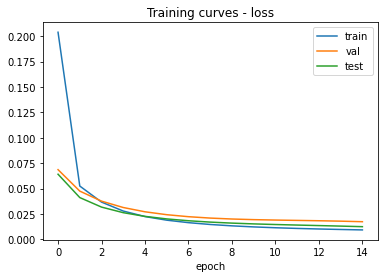

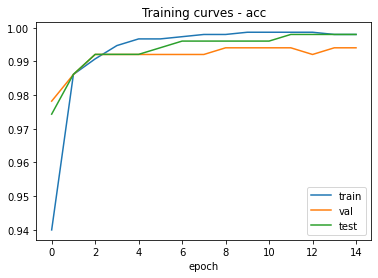

In [ ]:
plot_training_curves(training_curves_phase1, phases=['train', 'val', 'test'])

Como pueden observar, el modelo generaliza correctamente ya que los conjuntos de validacion y test no comienzan a diverger, como ocurriria en un caso de [overfitting](https://en.wikipedia.org/wiki/Overfitting).

## Matriz de confusion

Las matrices de confusion cuentan la cantidad de falsos positivos y falsos negativos.

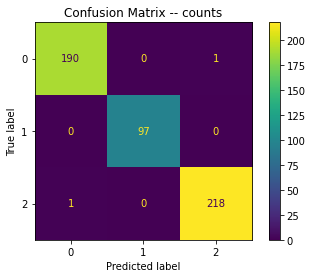

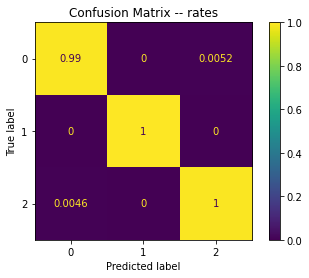

In [ ]:
res = plot_metrics(vit_b16_phase1, device, dataloaders, phase='test')

### Fase 2

Ahora que hemos alcanzado un rendimiento aceptable, vamos a descongelar todos los pesos y realizar una segunda fase de entrenamiento. Afinaremos tambien la segunda mitad de las capas de extraccion de atributos, ademas de la ultima capa de clasificacion.

In [ ]:
# Descongelar todos los pesos de la red
for param in vit_b16_phase1.parameters():
    param.requires_grad = True

# Congelar pesos especificos (La convolucion no se utiliza como tal, sino para partir la imagen en pedazos, VER EN EL PAPER!)
for param in vit_b16_phase1.conv_proj.parameters():
    param.requires_grad = False

# # Congelar los Transformer Encoders del 0 al 5 (primera mitad)
for i in range(6):
    for param in vit_b16_phase1.encoder.layers[i].parameters():
        param.requires_grad = False


In [ ]:
# Utilizo un ratio de aprendizaje mucho menor que el de la fase 1
learning_rate = 3e-7
num_epochs = 7

In [ ]:
# Perdida y optmizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_b16_phase1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo
vit_b16_phase2, training_curves_phase2 = train_classification_model(vit_b16_phase1, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.0096 Acc: 0.9987
val   Loss: 0.0171 Acc: 0.9941
test  Loss: 0.0112 Acc: 0.9980

Epoch 2/10
----------
train Loss: 0.0069 Acc: 0.9980
val   Loss: 0.0085 Acc: 0.9960
test  Loss: 0.0060 Acc: 1.0000

Epoch 3/10
----------
train Loss: 0.0037 Acc: 0.9993
val   Loss: 0.0058 Acc: 0.9980
test  Loss: 0.0062 Acc: 0.9980

Epoch 4/10
----------
train Loss: 0.0017 Acc: 1.0000
val   Loss: 0.0054 Acc: 0.9980
test  Loss: 0.0054 Acc: 0.9980

Epoch 5/10
----------
train Loss: 0.0012 Acc: 1.0000
val   Loss: 0.0050 Acc: 0.9980
test  Loss: 0.0051 Acc: 0.9980

Epoch 6/10
----------
train Loss: 0.0009 Acc: 1.0000
val   Loss: 0.0048 Acc: 0.9980
test  Loss: 0.0049 Acc: 0.9980

Epoch 7/10
----------
train Loss: 0.0008 Acc: 1.0000
val   Loss: 0.0047 Acc: 0.9980
test  Loss: 0.0048 Acc: 0.9980

Epoch 8/10
----------
train Loss: 0.0006 Acc: 1.0000
val   Loss: 0.0045 Acc: 0.9980
test  Loss: 0.0047 Acc: 0.9980

Epoch 9/10
----------
train Loss: 0.0005 Acc: 1.0000
val   Loss: 0.0045

## Fase 2 Resultados

| Prev State |   Learn Rate  | Epochs  | End Val Acc | End Test Acc |
| :----------| :-----------: | :-----: | :-----: | :------: |
| phase1_15eps | 2E-6 | 4 | 0.996 | 0.998 |
| phase1_15eps | 1E-6 | 5 | 0.998 | 1.000 |
| phase1_15eps | 2E-7 | 5 | 0.996 | 0.998 |
| phase1_15eps | 2E-8 | 10 | 0.996 | 0.998 |
| phase1_15eps | 1E-7 | 4 | 0.998 | 0.998 |
| phase1_15eps | 6E-8 | 5 | 0.998 | 0.998 |
| phase1_15eps | 5E-7 | 5 | 1.000 | 0.998 |
| phase1_15eps | 3E-7 | 6 | 0.998 | 0.998 |

Que un modelo tenga una precision mayor a otro no significa que sea directamente mejor, a veces una gran precision implica que un modelo no es muy bueno generalizando. Esto se deberia probar con un conjunto mas amplio de datos. Para elegir el modelo realice distintas pruebas manuales con otros conjuntos de datos para determinar los niveles de confusion y de generalizacion del modelo.

### Visualizar las curvas de entrenamiento y los resultados

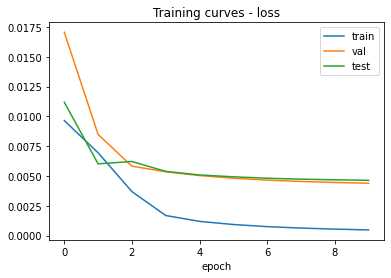

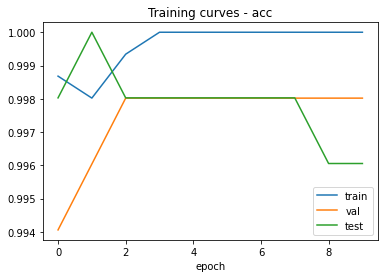

In [ ]:
plot_training_curves(training_curves_phase2, phases=['train', 'val', 'test'])

In [ ]:
torch.save(vit_b16_phase2.state_dict(), 'vit_lemons_weights_phase2_10eps_2.7E-7LR-better.pth')

In [ ]:
# Copiar los pesos desde la carpeta local y guardarlos en Drive
!cp vit_lemons_weights_phase2_10eps_2.7E-7LR-better.pth '/content/drive/MyDrive/Computadora/MIT ML/vit_checkpoints/'

In [ ]:
# Copiar los pesos guardados en Drive y traerlos a la carpeta Local
!cp '/content/drive/MyDrive/Computadora/MIT ML/vit_checkpoints/vit_lemons_weights_phase2_5eps_6E-8LR.pth' '/content/'

In [ ]:
# Copiar TODOS los checkpoints de GDrive a la carpeta local
!cp -r '/content/drive/MyDrive/Computadora/MIT ML/vit_checkpoints/.' '/content/'

In [ ]:
state_dict = torch.load('vit_lemons_weights_phase2_7eps_3E-7LR-BETter.pth', map_location=device)

vit_b16.load_state_dict(state_dict)
vit_b16_phase2 = vit_b16

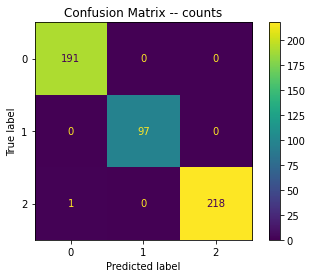

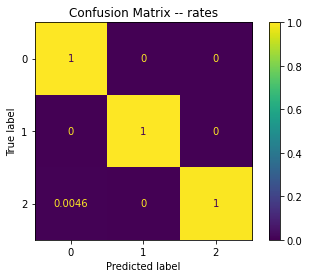

In [ ]:
res = plot_metrics(vit_b16_phase2, device, dataloaders, phase='test')

In [ ]:
# Limpiar RAM de la GPU

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# Prueba con imagenes completamente diferentes a las del dataset

### (Siempre se muetra la categoria predicha con mayor probabilidad en la imagen)

In [ ]:
# Load the dataset from the root folder with the specified transforms
random_dataset = ImageFolder('/content/drive/MyDrive/Computadora/MIT ML/random_lemons', transform=inference_transforms)

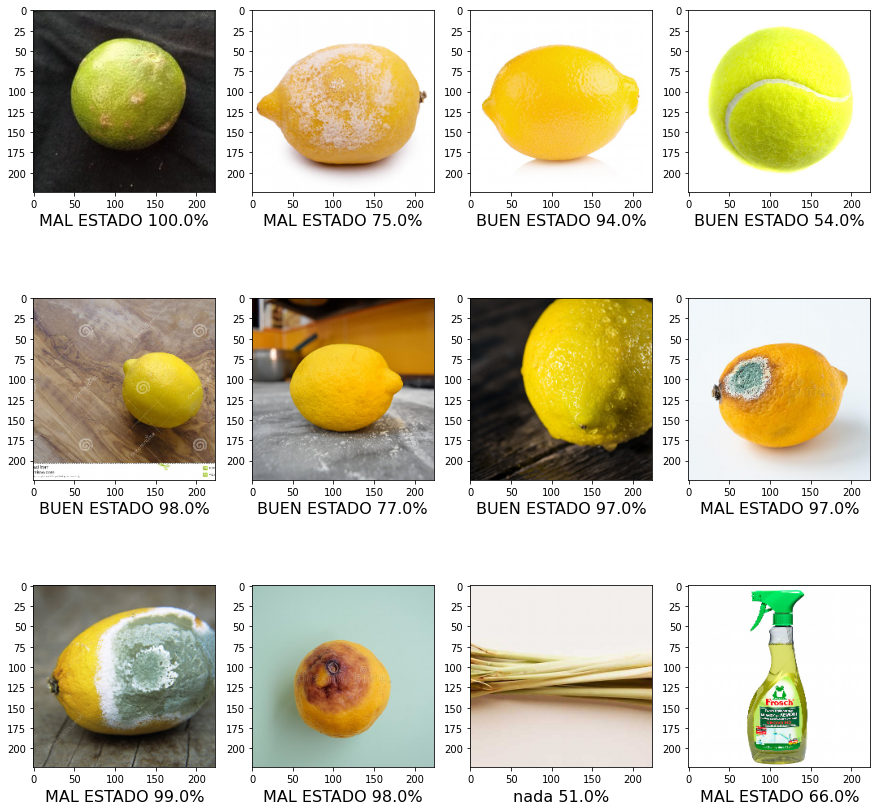

In [ ]:
labelNames = ["MAL ESTADO", "nada", "BUEN ESTADO"]

fig = plt.figure(figsize=(15,15))
figIdx = 1
for lemonID in range(12):
    # lemonID = 5
    randLemon = random_dataset[lemonID][0].unsqueeze(0)

    vit_out = torch.softmax(vit_b16_phase2.forward(randLemon.to(device)), dim=1)

    sorted_out, labels = torch.sort(vit_out.squeeze(), descending=True)

    ax = fig.add_subplot(3, 4, figIdx)
    view_lemon(randLemon.squeeze(0))
    labelText = f"{labelNames[labels[0]]} {(sorted_out[0]*100).round()}%"
    ax.text(0.5, -0.2, labelText, ha="center", va='bottom',transform=ax.transAxes, fontsize=16)
    figIdx += 1

# Observaciones
- Normalmente no se hacen este tipo de pruebas a la hora de entrenar modelos, o si se las hacen, se utilizan conjuntos de datos mas grandes.
- Honestamente no esperaba que el modelo funcione tan bien con este tipo de imagenes, porque son muy distintas al conjunto de entrenamiento en cuanto a formato, fondo y otros detalles.
- Notar que cuando al modelo se le presenta una imagen de un objeto que no tiene nada que ver con un Limon, el grado de certeza del modelo sobre su prediccion (Porcentaje al lado de la categoria) baja considerablemente. En cambio con el resto de imagenes, la certeza es bastante alta (la mayoria son mayores al 90% y la menor certeza es del 75%)
- El valor de la certeza puede usarse como un umbral de seguridad para determinar cuando una prediccion es correcta o es dudosa.
- Este modelo no se puede utilizar en sistemas de tiempo real por su lentitud, para ello se podrian probar otros modelos como YOLO v8, que a dia de hoy es el estado del arte en su categoria



### Algunas referencias
 - [Pytorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
 - [Dive into Deep Learning (2021)](https://d2l.ai/)
 - [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
 - [Lemons quality control dataset](https://github.com/robotduinom/lemon_dataset#lemons-quality-control-dataset-lemon)